In [1]:
import os
import sktime
from sktime.datasets import load_from_tsfile_to_dataframe
from tslearn.clustering import TimeSeriesKMeans
# from tslearn.preprocessing import TimeSeriesScalerMeanVariance
# from tslearn.preprocessing import TimeSeriesResampler
import matplotlib.pyplot as plt
import numpy as np
import signatory
import torch
import mean_pennec
import pandas as pd
import time

In [2]:
X_train, y_train = load_from_tsfile_to_dataframe("./data/PenDigits/PenDigits_TRAIN.ts")
X_test, y_test = load_from_tsfile_to_dataframe("./data/PenDigits/PenDigits_TEST.ts")

In [3]:
X = pd.concat([X_train, X_test], ignore_index=True)
y_true = np.concatenate((y_train, y_test))

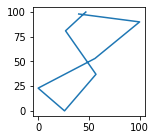

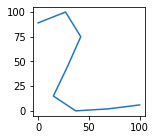

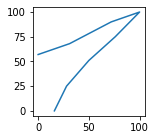

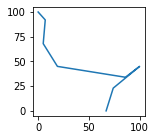

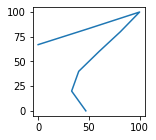

In [4]:
for k in range(5):
    plt.figure(figsize=(2,2))
    plt.plot(X.at[k,'dim_0'], X.at[k,'dim_1'])

In [21]:
np.unique(y_true, return_counts=True)

(array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1'),
 array([1143, 1143, 1144, 1055, 1144, 1055, 1056, 1142, 1055, 1055]))

**Remark.** Each class represent an equal proportion of the data.

In [5]:
X = X.to_numpy()

In [6]:
X.shape

(10992, 2)

In [7]:
batch = X.shape[0]
stream = len(X[0,0])
channels = X.shape[1]

In [8]:
Xtemp = np.empty((batch, stream, channels))
for obs in range(batch):
    for channel in range(channels):
        Xtemp[obs, :, channel] = X[obs, channel]

In [9]:
Xtemp = torch.from_numpy(Xtemp)
X = Xtemp

In [10]:
def datascaling(data):
    "Each observation is set to have total variation norm equals to 1."
    batch, stream, channels = data.shape
    print(f"stream = {stream}")
    for i in range(batch):
        tvnorm = np.array([(data[i, k, :] - data[i, k-1, :]).numpy() for k in range(1, stream)])
        tvnorm = np.sum(tvnorm, axis=0)
        tvnorm = np.linalg.norm(tvnorm)
        print(f"tvnorm obs #{i} = {tvnorm}")
        data[i] = data[i]/tvnorm
        print(data[i])
    return(data)

**STEP 1.**  dataset of paths `X` already normalized.

In [11]:
depth = 5
SX = signatory.signature(X, depth=depth)

In [12]:
SX

tensor([[-7.0000e+00, -2.0000e+00,  2.4500e+01,  ...,  3.3482e+08,
         -8.5188e+07, -2.6667e-01],
        [ 1.0000e+02, -8.3000e+01,  5.0000e+03,  ..., -3.6765e+07,
          1.8003e+08, -3.2825e+07],
        [ 1.6000e+01, -5.7000e+01,  1.2800e+02,  ..., -2.3007e+07,
         -5.6107e+05, -5.0141e+06],
        ...,
        [-1.8000e+01, -7.0000e+00,  1.6200e+02,  ..., -8.0391e+08,
          2.1789e+08, -1.4006e+02],
        [-9.0000e+00, -1.9000e+01,  4.0500e+01,  ..., -7.5918e+08,
          2.4092e+08, -2.0634e+04],
        [ 2.7000e+01, -1.0000e+02,  3.6450e+02,  ...,  9.2496e+07,
          2.5937e+07, -8.3333e+07]], dtype=torch.float64)

In [13]:
SX.shape

torch.Size([10992, 62])

In [14]:
def kmeans(k, signatures, depth, channels, max_iterations, verbose=False):
    """
    Perform k-means on a dataset of signatures.
    """
    batch, siglen = signatures.shape
    y = -1*np.ones(batch, dtype='int')  # corresponding cluster index for each obs
    timestr = time.strftime("%Y%m%d_%H%M%S")
    logsfilename = f'./logs/log_clusteridx_{timestr}.txt'
    with open(logsfilename, 'w') as the_file:
        the_file.write('')
    # INITIALIZATION
    # choose k obs randomly to start from
    rd_idx = np.random.randint(batch, size=k)
    means = signatures[rd_idx]
    for iteration in range(max_iterations):
        # if iteration%5==0:
        print(f"iteration #{iteration}")
        # ASSIGN OBS TO CLUSTER W/ NEAREST CENTROID
        for idx, sig in enumerate(signatures):  # L2 DISTANCE
            id_cluster = np.argmin([torch.norm(sig-means[i]) for i in range(k)])
            y[idx] = id_cluster
        # UPDATE MEAN VALUES TO MEAN OF CLUSTER
        sum1 = 0
        for i in range(k):
            to_average = signatures[y==i, :]  # select obs of cluster i
            sum1 += to_average.shape[0]
            if not len(to_average)==0:
                means[i] = mean_pennec.mean(to_average, depth, channels)
        if verbose:
            print(f"SUM  = {sum1}")
            print(f"first cluster indices : {y[:15]}")
            print(f"mean values") 
            print((means[0])[14:24])
            print((means[3])[14:24])
            print((means[6])[14:24])
        with open(logsfilename, 'a') as the_file:
            the_file.write(f'{list(y)}\n')
    return(y)

In [22]:
start = time.time()
y = kmeans(k=10, 
           signatures=SX, 
           depth=depth, 
           channels=channels, 
           max_iterations=30)
end = time.time()
print(f"duration of algorithm : {np.around((end-start)/60, 2)} min")

iteration #0
iteration #1
iteration #2
iteration #3
iteration #4
iteration #5
iteration #6
iteration #7
iteration #8
iteration #9
iteration #10
iteration #11
iteration #12
iteration #13
iteration #14
iteration #15
iteration #16
iteration #17
iteration #18
iteration #19
iteration #20
iteration #21
iteration #22
iteration #23
iteration #24
iteration #25
iteration #26
iteration #27
iteration #28
iteration #29
duration of algorithm : -27.491 min


In [23]:
y_true

array(['8', '2', '1', ..., '0', '0', '4'], dtype='<U1')

In [24]:
y_true=='8'

array([ True, False, False, ..., False, False, False])

In [25]:
y[:15]

array([2, 1, 1, 1, 1, 1, 1, 8, 3, 9, 6, 2, 6, 6, 1])

In [26]:
y_true[:15]

array(['8', '2', '1', '4', '1', '6', '4', '0', '5', '0', '9', '8', '5',
       '9', '7'], dtype='<U1')

In [30]:
for i in range(10):
    print(f"true number = {i} ;", np.unique(y[y_true==f'{i}'], return_counts=True))

true number = 0 ; (array([1, 2, 4, 7, 8, 9]), array([  9,  15,  46,   8, 600, 465]))
true number = 1 ; (array([0, 1]), array([  51, 1092]))
true number = 2 ; (array([1, 4, 5]), array([1087,   53,    4]))
true number = 3 ; (array([0, 1, 4]), array([997,  57,   1]))
true number = 4 ; (array([1, 4, 6]), array([1134,    2,    8]))
true number = 5 ; (array([0, 1, 3, 5, 6, 7]), array([ 54, 223, 330,  25, 170, 253]))
true number = 6 ; (array([1, 3, 4, 8, 9]), array([167,   1, 857,   1,  30]))
true number = 7 ; (array([0, 1, 5]), array([ 42, 384, 716]))
true number = 8 ; (array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 11, 341, 322,   1,  37,  10,   1, 331,   1]))
true number = 9 ; (array([0, 1, 2, 4, 6, 7]), array([ 75, 488,   4,  66, 418,   4]))
